
<p style="display:block;text-align:center;font-weight:700;font-size:40px">
  <em>Эссе №2</em>
</p>

<p style="display:block;text-align:center;font-style:italic;font-weight:700;font-size:40px">
  <em>Код Хаффмана на реальном тексте</em>
</p>

## **Теория**

##### **Префиксный код (instantaneous code)**
- **Определение.** Ни одно кодовое слово не является префиксом другого ⇒ декодирование «на лету» по обходу дерева.
- **Бинарное дерево.**: путь от корня до листа = код слова (лево=0, право=1). Листья — символы алфавита.
- **Средняя длина.** $\bar L=\sum_i p_i\,l_i$, где $l_i$ — длина кода символа $i$, $p_i$ — его вероятность.


##### **Неравенство Крафта–Макмиллана**
- **Условие существования префиксного кода** с длинами $l_i$:  $$  \sum_i 2^{-l_i} \le 1.  $$
- **Необходимо и достаточно.** Если набор длин удовлетворяет сумме, можно построить префиксный код с такими длинами.
- **Интерпретация.** Каждый лист «занимает» долю $2^{-l_i}$ полной мощности двоичного дерева; сумма не должна превышать 1.



##### **Код Хаффмана (оптимальный префиксный код)**
- **Задача.** Минимизировать $\bar L=\sum_i p_i\,l_i$ при префиксности, зная вероятности $p_i$.
- **Алгоритм (жадный, снизу вверх).**
  1) Поместить все символы с их $p$ в приоритетную очередь (минимум наверху).
  2) Повторять: взять **два** наименее вероятных узла, слить в новый узел с весом суммы; вернуть в очередь.
  3) Когда остаётся один узел — это корень; глубины листьев дают длины $l_i$, ветви помечаются битами 0/1.
- **Свойства.**
  - **Оптимальность:** для заданных $p_i$ код Хаффмана минимизирует $\bar L$ среди всех префиксных кодов.
  - **Границы эффективности:** 
    $$ H \;\le\; \bar L_{\text{Huff}} \;<\; H+1, \quad
    H=-\sum_i p_i\log_2 p_i.  $$
- **Практика.** Базовый кирпич современных архиваторов/кодеков (в чистом виде или как подблок): короткие коды для частых символов, длинные — для редких.


## **Практика**

In [22]:
import math
import heapq
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt

In [23]:
'''препроцессинг'''
KEEP_CASE = False      # False -> приводить к нижнему регистру
KEEP_SPACES = True     # True  -> оставлять пробелы как символ
KEEP_PUNCT = True      # True  -> оставлять пунктуацию

def preprocess_from_file(path, keep_case=False, keep_spaces=True, keep_punct=True):
    import re
    
    with open(path, "r", encoding="cp1251") as f:
        text = f.read()

    # регистр
    if not keep_case:
        text = text.lower()

    # нормализация пробелов
    if keep_spaces:
        text = re.sub(r"\s+", " ", text)
    else:
        text = re.sub(r"\s+", "", text)

    # фильтр пунктуации (оставляем только цифры/буквы/пробел)
    if not keep_punct:
        text = re.sub(r"[^0-9a-zа-яё ]+", "", text)

    return text

In [24]:
TEXT_PATH = "data/Ulitka_na_sklone.txt" # братья Стругацкие, Улитка на склоне

text = preprocess_from_file(TEXT_PATH,
                            keep_case=False,
                            keep_spaces=True,
                            keep_punct=True)   
print("Длина текста символов:", len(text))
print("Пример:", repr(text[:200]))

Длина текста символов: 163098
Пример: 'но лес оставался безразличен. он был так безразличен, что даже не был виден. под обрывом была тьма, и только на самом горизонте что-то широкое и слоистое, серое и бесформенное вяло светилось в сиянии '


In [25]:
'''Частоты, вероятности и энтропия'''
cnt = Counter(text) # вернет словарь вида {символ: сколько раз встретился}
N = sum(cnt.values())
alphabet = sorted(cnt.keys()) # список уникальных символов
M = len(alphabet)

probs = {ch: cnt[ch] / N for ch in alphabet} # эмпирические вероятности

def entropy_bits(prob_dict) -> float:
    '''энтропия Шеннона в битах'''
    s = 0.0
    for p in prob_dict.values():
        if p > 0.0:
            s -= p * math.log2(p)
    return s

H = entropy_bits(probs)
print(f"Длина текста: {N} символов, алфавит: {M}")
print(f"Энтропия H ≈ {H:.4f} бит/символ")

# Базовый фиксированный код по размеру алфавита:
L_fixed = math.ceil(math.log2(M)) if M > 1 else 0
print(f"Фиксированный код: {L_fixed} бит/символ")

Длина текста: 163098 символов, алфавит: 48
Энтропия H ≈ 4.5484 бит/символ
Фиксированный код: 6 бит/символ


In [26]:
'''листок дерева'''

class Node: # один узел
    __slots__ = ("p", "sym", "left", "right")
    def __init__(self, p, sym=None, left=None, right=None):
        self.p = p #вес узла
        self.sym = sym # сам символ (для внутренних узлов = None)
        self.left = left
        self.right = right # ссылки на левое/правое деревья (у листа = None)
        
    def __lt__(self, other):  # чтобы heapq.heappop мог вытаскивать узел с наименьшим p (по вероятности)
        return self.p < other.p

In [27]:
def build_huffman_tree(prob_dict):
    '''Классическое дерево Хаффмана в виде кучи из листьев'''
    heap = []
    uid = 0  # счётчик для стабильности при равных p
    for ch, p in prob_dict.items():
        heapq.heappush(heap, (p, uid, Node(p, sym=ch))) 
        # кладем все символы как листья в кучу (сначала сравниваем по p)
        uid += 1
        # Node(p, sym=ch) — лист с весом p и символом ch.
    if len(heap) == 1:
        # крайний случай: один символ -  код = 0
        p, _, only = heapq.heappop(heap)
        root = Node(p, left=only, right=None)
        return root

    while len(heap) > 1:
        # вытаскиваем два самых лёгких узла n1, n2 с весами p1, p2
        p1, _, n1 = heapq.heappop(heap)
        p2, _, n2 = heapq.heappop(heap)
        # создаем их общего родителя с весом p1+ p2
        parent = Node(p1 + p2, left=n1, right=n2)
        # и кладем родилеля обратно в кучу
        heapq.heappush(heap, (parent.p, uid, parent))
        uid += 1
    return heapq.heappop(heap)[2]  # корень дерева

Сложность такого алгоритма для алфавита из $M$ символов - примерно $O(MlogM)$.  
Длина кода символа = глубине листа с этим символом в дереве.

In [28]:
'''Обход дерева и сбор длин кодов'''
def extract_codes_from_tree(root):
    codes = {} # коды символов
    lengths = {} # длины кодов символов
    def dfs(node, path):
        '''Сама функция обхода дерева'''
        if node.sym is not None: # если узел это лист
            codes[node.sym] = path if path != "" else "0"  # один символ в алфавите
            lengths[node.sym] = len(codes[node.sym])
            return
        # дальше если узел не лист то рекурсивно спускаемся вглубь вправо или влево
        if node.left is not None:
            dfs(node.left, path + "0")
        if node.right is not None:
            dfs(node.right, path + "1")

    dfs(root, "") #вызываем обход дерева от корня
    return codes, lengths

In [29]:
# строим дерево и извлекаем коды и длины
root = build_huffman_tree(probs)
codes, lengths = extract_codes_from_tree(root)
# считаем с реднюю длину кода
avg_len = sum(probs[ch] * lengths[ch] for ch in alphabet)
print(f"Средняя длина кода Хаффмана   ≈ {avg_len:.4f} бит/символ")
if H < avg_len: print(f"Границы: H ≤ L < H+1 -> {H:.4f} ≤ {avg_len:.4f} < {H+1:.4f}")

Средняя длина кода Хаффмана   ≈ 4.5817 бит/символ
Границы: H ≤ L < H+1 -> 4.5484 ≤ 4.5817 < 5.5484


Неравенству Крафта автоматически удовлетворяем, т к алгоритм построения дерева Хаффмана строит префиксный код (листья дерева не перекрываются).

In [30]:
'''Кодирование / декодирование'''
def huffman_encode(text, codebook):
    '''кодирование'''
    # идем по символам исходного текста и складываем их коды друг за другом
    # на выходе - строка из 0 и 1 без разделителей
    return "".join(codebook[ch] for ch in text)

def huffman_decode(bitstring, root):
    '''декодирование'''
    out = []
    node = root
    for b in bitstring:
        node = node.left if b == "0" else node.right
        if node.sym is not None:  # достигли листа - значит прочитали 1 кодовое слово
            out.append(node.sym) # добавляем символ в ответ
            node = root # сбрасываемся в корень дерева
    return "".join(out) # склеиваем все в строку

bitstream = huffman_encode(text, codes)
decoded = huffman_decode(bitstream, root)
print("Проверка кодирование-декодирование:", "OK" if decoded == text else "DECODE MISMATCH")

total_bits = len(bitstream)
print(f"Бит на весь текст: {total_bits} (≈ {total_bits/N:.4f} бит/символ)")

Проверка кодирование-декодирование: OK
Бит на весь текст: 747258 (≈ 4.5817 бит/символ)


Эффективность η = H / L ≈ 0.9927
Разница R = L - H ≈ 0.0332 бит/символ
В сравнении с фикс кодом: 4.5817 vs 6 (бит/символ)


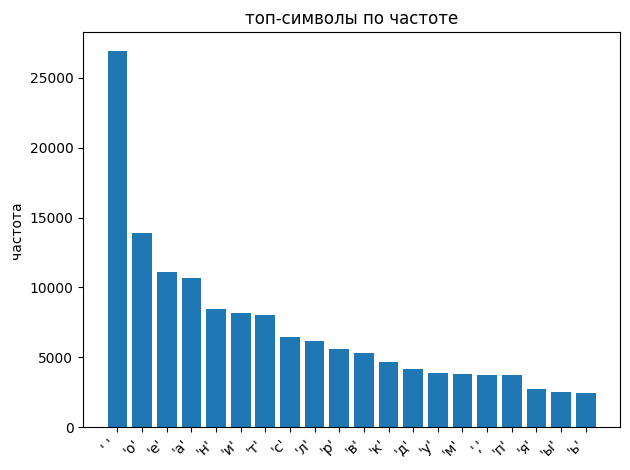

' ' 26918
'о' 13875
'е' 11111
'а' 10688
'н' 8453
'и' 8172
'т' 8011
'с' 6472
'л' 6193
'р' 5597


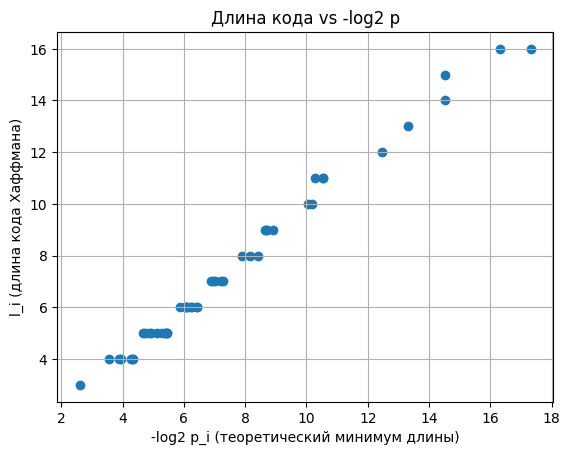

In [35]:
efficiency = H / avg_len if avg_len > 0 else 1.0
redundancy = avg_len - H

print(f"Эффективность η = H / L ≈ {efficiency:.4f}")
print(f"Разница R = L - H ≈ {redundancy:.4f} бит/символ")
print(f"В сравнении с фикс кодом: {avg_len:.4f} vs {L_fixed} (бит/символ)")

top = 20
items = sorted(cnt.items(), key=lambda x: x[1], reverse=True)[:top]
labels = [repr(k) for k, _ in items]  # чтобы видеть пробелы/переносы
vals = [v for _, v in items]

plt.figure()
plt.bar(range(len(vals)), vals)
plt.xticks(range(len(vals)), labels, rotation=45, ha='right')
plt.ylabel("частота")
plt.title("топ-символы по частоте")
plt.tight_layout()
plt.show()

for ch, v in items[:10]:
    print(repr(ch), v)

# Рассеяние: -log2(p) vs фактическая длина l (ожидание: близко)
neglogp = np.array([-math.log2(probs[ch]) for ch in alphabet])
lens = np.array([lengths[ch] for ch in alphabet])

plt.figure()
plt.scatter(neglogp, lens)
plt.xlabel("-log2 p_i (теоретический минимум длины)")
plt.ylabel("l_i (длина кода Хаффмана)")
plt.title("Длина кода vs -log2 p")
plt.grid(True)
plt.show()

Отклонения от ровной диагонали $x=y$ из за квантования до целых бит.


Энтропия текста: ~4.55 бит/симв. Префиксный код Хаффмана даёт ~4.58 бит/симв (разница ~0.033 бит/симв), что близко к теоретическому пределу.   
Относительно фиксированного 6-битного кода по M=48 экономия ~24%,  
относительно cp1251 (8 бит/симв) — ~43% по объёму данных.

## **Применимость подхода**


- **Архиваторы и форматы:** базовый кирпич в ZIP/gzip/DEFLATE, PNG (внутри — Хаффман над символами потоков), JPEG (кодовые таблицы Хаффмана для коэффициентов), многие аудио/видео кодеки используют вариации префиксного кодирования.
- **Логи и телеметрия:** коды разной длины для «частых» событий/тегов → уменьшение трафика/хранилища без потерь.
- **Встраиваемые и realtime-системы:** префиксность -> мгновенное декодирование по дереву/таблице (без буферов и плавающей точки) — дешёво и быстро на железе/микроконтроллерах.
- **Протоколы и словари:** компактные идентификаторы/токены для часто встречающихся строк/ключей (RPC, сериализация, кеши).
- **Текст/JSON/лог-файлы:** простой способ уменьшить объём без сложной модели.


**Почему именно код Хаффмана**
- **Оптимален среди префиксных кодов:** для известных вероятностей даёт минимальную среднюю длину $\bar L$ с гарантией $H \le  L < H+1$.
- **Прост и быстp:** построение $O(M\log M)$, кодирование/декодирование $O(N)$; реализация — куча + дерево/таблица.
- **Детерминирован и переносим:** канонический вариант хранит только длины кодов.
- **Кодирует по границе:** показали, как близко можно подойти к энтропийному пределу и где остаётся разница.



## **Литература**

https://ru.wikipedia.org/wiki/Информационная_энтропия   
https://ru.wikipedia.org/wiki/Префиксный_код  
https://ru.wikipedia.org/wiki/Неравенство_Крафта_—_Макмиллана  
https://ru.wikipedia.org/wiki/Код_Хаффмана  

https://pythonread.github.io/dsa/huffman-coding.html  
https://habr.com/ru/companies/otus/articles/497566/  
